# Simplified Hierarchical Morphotope Classification

This tutorial walks through a simplified workflow inspired by the [Urban Taxonomy using Hierarchical Morphotope Classification](https://urbantaxonomy.org/) project. The project aims to delineate areas with similar morphological character—configurations of streets, buildings, and the space between them.

The original project covers every street and building in a large portion of European countries, using over 200 million data points with 60 features each. This tutorial focuses on a smaller area, fewer features, and a simplified analysis to demonstrate the core concepts.

For details, see the full [project page](https://urbantaxonomy.org/) and the related [GitHub repository](https://github.com/uscuni/urban_taxonomy/).

In [1]:
import libpysal
import matplotlib.pyplot as plt
import momepy
import neatnet
import numpy as np
import osmnx
import pandas as pd
from scipy.cluster import hierarchy
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from spopt.region import SA3

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = "Znojmo, Czechia"
local_crs = 5514

## Buildings

One of the core elements of the analysis are detailed building footprints. To get the data, we first read all the possible information for buildings from Open Streetmap maps for our specified location. We then carry out some preprocessing to address data inconsistencies and quality problems.

In [3]:
buildings = osmnx.features_from_place(place, tags={"building": True})
buildings.head()

geometry building bunker_type historic  \
element id                                                                    
node    3372076291  POINT (16.05376 48.84683)   bunker     pillbox      yes   
        3372076393  POINT (16.05581 48.84158)   bunker     pillbox      yes   
        3372076394  POINT (16.05867 48.83522)   bunker     pillbox      yes   
        3372076428  POINT (16.03949 48.85599)   bunker     pillbox      yes   
        3372076429  POINT (16.04133 48.85501)   bunker     pillbox      yes   

                   military            name ref:ropiky.net      source  \
element id                                                               
node    3372076291   bunker    7/I/10/A-120     1105625216  ropiky.net   
        3372076393   bunker  7/I/11/A-140 Z     1105625217  ropiky.net   
        3372076394   bunker    7/I/12/A-220     1105625218  ropiky.net   
        3372076428   bunker         7/I/8/E     1105625214  ropiky.net   
        3372076429   bunker         7/I/9/E     1105625215  ropiky.net   

                                                              website amenity  \
element id                                                                      
node    3372076291  https://ropiky.net/dbase_objekt.php?id=1105625216     NaN   
        3372076393  https://ropiky.net/dbase_objekt.php?id=1105625217     NaN   
        3372076394  https://ropiky.net/dbase_objekt.php?id=1105625218     NaN   
        3372076428  https://ropiky.net/dbase_objekt.php?id=1105625214     NaN   
        3372076429  https://ropiky.net/dbase_objekt.php?id=1105625215     NaN   

                    ... fuel:octane_91 material name:signed  ref  \
element id          ...                                            
node    3372076291  ...            NaN      NaN         NaN  NaN   
        3372076393  ...            NaN      NaN         NaN  NaN   
        3372076394  ...            NaN      NaN         NaN  NaN   
        3372076428  ...            NaN      NaN         NaN  NaN   
        3372076429  ...            NaN      NaN         NaN  NaN   

                   monitoring:water_level takeaway shelter_type construction  \
element id                                                                     
node    3372076291                    NaN      NaN          NaN          NaN   
        3372076393                    NaN      NaN          NaN          NaN   
        3372076394                    NaN      NaN          NaN          NaN   
        3372076428                    NaN      NaN          NaN          NaN   
        3372076429                    NaN      NaN          NaN          NaN   

                   type emergency  
element id                         
node    3372076291  NaN       NaN  
        3372076393  NaN       NaN  
        3372076394  NaN       NaN  
        3372076428  NaN       NaN  
        3372076429  NaN       NaN  

[5 rows x 117 columns]

Filter out polygons that are not single structures.

In [4]:
buildings = buildings[buildings.geom_type == "Polygon"]

And those that do not represent buildings.

In [5]:
unwanted = [
    "garage",
    "garages",
    "shed",
    "bungalow",
    "roof",
    "parking",
    "kiosk",
    "hut",
    "pavilion",
    "greenhouse",
    "cabin",
    "toilets",
    "farm_auxiliary",
    "guardhouse",
    "bunker",
    "transportation",
    "ruins",
    "transformer_tower",
    "gatehouse",
    "hangar",
]

buildings = buildings[~buildings["building"].isin(unwanted)]
# drop barries such as city walls
buildings = buildings[~buildings.barrier.notna()]

And we should re-project the data from WGS84 to the local projection in meters (momepy default values assume meters not feet or degrees). We will also drop unnecessary columns and structures that are too small.

In [6]:
buildings = buildings[["geometry"]].to_crs(local_crs)
buildings = buildings[buildings.area > 25].reset_index(drop=True)
buildings.head()

,geometry
0,"POLYGON ((-642818.791 -1194246.301, -642822.90..."
1,"POLYGON ((-643052.212 -1193474.914, -643069.77..."
2,"POLYGON ((-642796.708 -1193674.586, -642795.74..."
3,"POLYGON ((-642960.567 -1193475.288, -642969.02..."
4,"POLYGON ((-642973.521 -1193481.346, -642960.58..."


### Streets

Similarly, the streets geometries also come from OpenStreetMap.

In [7]:
osm_graph = osmnx.graph_from_place(place, network_type="drive")
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)
streets.head()

,osmid,highway,maxspeed,name,ref,oneway,reversed,length,from,to,geometry,lanes,bridge,junction,width,tunnel,access
0,33733060,secondary,50,Přímětická,361,False,True,24.573585,639231391,74103628,"LINESTRING (-643229.639 -1192872.949, -643239....",NaN,NaN,NaN,NaN,NaN,NaN
1,33733060,secondary,50,Přímětická,361,False,False,60.353202,3775990798,74103628,"LINESTRING (-643236.395 -1192790.304, -643237....",NaN,NaN,NaN,NaN,NaN,NaN
2,50313252,residential,NaN,Raisova,NaN,True,False,74.762885,639231413,74103628,"LINESTRING (-643291.344 -1192797.012, -643288....",NaN,NaN,NaN,NaN,NaN,NaN
3,33733060,secondary,50,Přímětická,361,False,True,54.260241,74142638,639231391,"LINESTRING (-643205.434 -1192921.533, -643219....",NaN,NaN,NaN,NaN,NaN,NaN
4,50313241,residential,NaN,Mičurinova,NaN,True,False,101.376850,639231391,639231314,"LINESTRING (-643229.639 -1192872.949, -643233....",NaN,NaN,NaN,NaN,NaN,NaN


We carry out some preprocessing to drop unwated street segments such as tunnels, underground segments, or footpaths.

In [8]:
## service road removed
approved_roads = [
    "living_street",
    "motorway",
    "motorway_link",
    "pedestrian",
    "primary",
    "primary_link",
    "residential",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "trunk",
    "trunk_link",
    "unclassified",
]
streets = streets[streets["highway"].isin(approved_roads)]

The downloaded streets reflect the routing structure of the network, however we are more interested in its overall physical representation. For example dual-carriageways should be repreesented as one line, and roundabouts as an intersection of roads.

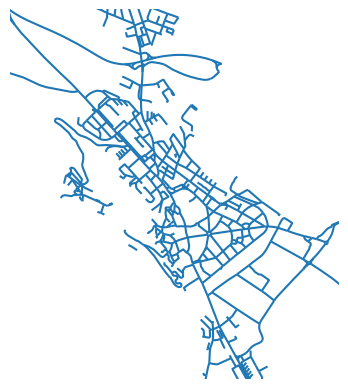

In [9]:
ax = streets.plot()
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()

We generate this representation from the routing represetntation using the open source Python package `neatnet`.

In [10]:
streets = streets.to_crs(epsg=local_crs)
streets = streets[["geometry", "highway"]].reset_index(drop=True)

## simplify
streets = neatnet.neatify(
    streets,
    exclusion_mask=buildings.geometry,
    artifact_threshold_fallback=7,
)

/Users/martin/dev/pysal/.pixi/envs/default/lib/python3.11/site-packages/neatnet/simplify.py:877: UserWarning: No threshold for artifact detection found. Using the set fallback value of 7.
  artifacts, threshold = get_artifacts(


We can see in comparison, that the transportation geometry is now replaced by the morphological one.

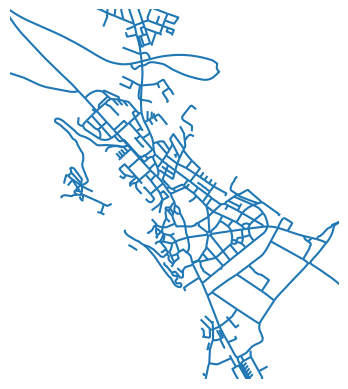

In [11]:
ax = streets.plot()
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()

## Generated data

### Tessellation

We can generate a spatial unit using enclosed tessellation, which aims to approximate plots and captures the area that is nearest to each building, bounded by specified enclosures such as streets, rivers, rail networks, etc. Its formal definition is :

> The portion of space that results from growing a morphological tessellation within an enclosure delineated by a series of natural or built barriers identified from the literature on urban form, function and perception.

Morpohological tessellation is a method to divide space into cells based on building footprints and Voronoi tessellation.

More information is available [here](https://www.sciencedirect.com/science/article/pii/S0197397522001382).

To create the tessellation, first we create the enclosures based on the street network only. We use an adaptive limit to bound the enclosures, based on the distances to surrounding buildings. The aim is to avoid boundary effects at the edges of the study area. Tessellation cells with a negative index represent empty space with no associated buildings. The are still used in the analysis, to preserve contiguity and neighbourhood information.

In [12]:
limit = momepy.buffered_limit(buildings, "adaptive")
enclosures = momepy.enclosures(streets, limit=limit, clip=True)
tessellation = momepy.enclosed_tessellation(buildings, enclosures)

OpenStreetMap data are often problematic due to low quality of some polygons. We get a mismatch between the length of buildings data frame and the length of tessellation dataframe. Therefore, we carry out some ETC post processing:
1. We drop all buildings that collapse into multiple parts during the processing
2. We redo the tessellation
3. We process the multipolygon tessellation geometries by combining split ETCs and droping any empty space belonging to a particular building 

In [13]:
collapsed, multipolygons = momepy.verify_tessellation(tessellation, buildings)

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_58761/3617767949.py:1: UserWarning: Tessellation does not fully match buildings. 0 element(s) disappeared during generation. Index of the affected elements: Index([], dtype='int64').
  collapsed, multipolygons = momepy.verify_tessellation(tessellation, buildings)
/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_58761/3617767949.py:1: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. Index of affected elements: [165, 42, 1247, 1262, 1384, 1394, 3182, 3189, 3203, 3221, 3259, 3269, 3689, 4027, 5264, 5265, 5273, 6874, 6889, 6895, 6961, 6969, 1736, 1759, 1046, 2203, 4776, 6219, 8384, 986, 991, 28, 2182, 2607, 2616, 4767, 4768, 5375, 4702, 7181, 7085, 7982, 589, 601, 608, 613, 2225, 2650, 2659, 2664, 3314, 5184, 5340, 6685, 6697, 8104, 8185, 8427, 1244, 1842, 1894, 1923, 8390, 5493, 6294, 4000, 5056, 1180, 1170, 1205, 1206, 1215, 1238, 1239, 7672, 7776, 3398, 1366, 1367, 1368, 3892

In [14]:
buildings = buildings.drop(collapsed).reset_index(drop=True)
limit = momepy.buffered_limit(buildings, "adaptive")
enclosures = momepy.enclosures(streets, limit=limit, clip=True)

tessellation = momepy.enclosed_tessellation(buildings, enclosures)

In [15]:
def postprocess_tessellation(tessellation):
    # deal with split buildings
    tessellation = tessellation.dissolve(by=tessellation.index.values)

    # drop empty spaces with no buildings and a positive index,
    # leave negatives in the geodataframe
    tessellation = tessellation.explode()
    inp, res = buildings.geometry.centroid.sindex.query(tessellation.geometry)
    to_keep = np.append(
        np.unique(inp), np.where(tessellation.index.values < 0)[0]
    )
    tessellation = tessellation.iloc[to_keep]

    ### drop any remaining duplicates
    ## sometimes -1s have multiple tesselation cells
    tessellation = tessellation[~tessellation.index.duplicated()].sort_index()
    return tessellation

In [16]:
tessellation = postprocess_tessellation(tessellation)

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [17]:
buildings["street_index"] = momepy.get_nearest_street(
    buildings, streets, max_distance=50
)
buildings

,geometry,street_index
0,"POLYGON ((-642818.791 -1194246.301, -642822.90...",335.0
1,"POLYGON ((-643052.212 -1193474.914, -643069.77...",468.0
2,"POLYGON ((-642796.708 -1193674.586, -642795.74...",353.0
3,"POLYGON ((-642960.567 -1193475.288, -642969.02...",476.0
4,"POLYGON ((-642973.521 -1193481.346, -642960.58...",476.0
...,...,...
8424,"POLYGON ((-641738.98 -1194785.095, -641735.517...",NaN
8425,"POLYGON ((-641757.158 -1194540.484, -641755.62...",14.0
8426,"POLYGON ((-641448.568 -1194539.939, -641439.29...",NaN
8427,"POLYGON ((-641621.21 -1193537.463, -641627.707...",102.0


Aattach the network index to the tessellation as well.

In [18]:
tessellation["street_index"] = buildings["street_index"]

## Measure

Measure individual morphometric characters. For details see the User Guide and the API reference.

### Dimensions

In [19]:
buildings["building_area"] = buildings.area
tessellation["tess_area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [20]:
buildings["eri"] = momepy.equivalent_rectangular_index(buildings)
buildings["elongation"] = momepy.elongation(buildings)
tessellation["convexity"] = momepy.convexity(tessellation)
streets["linearity"] = momepy.linearity(streets)

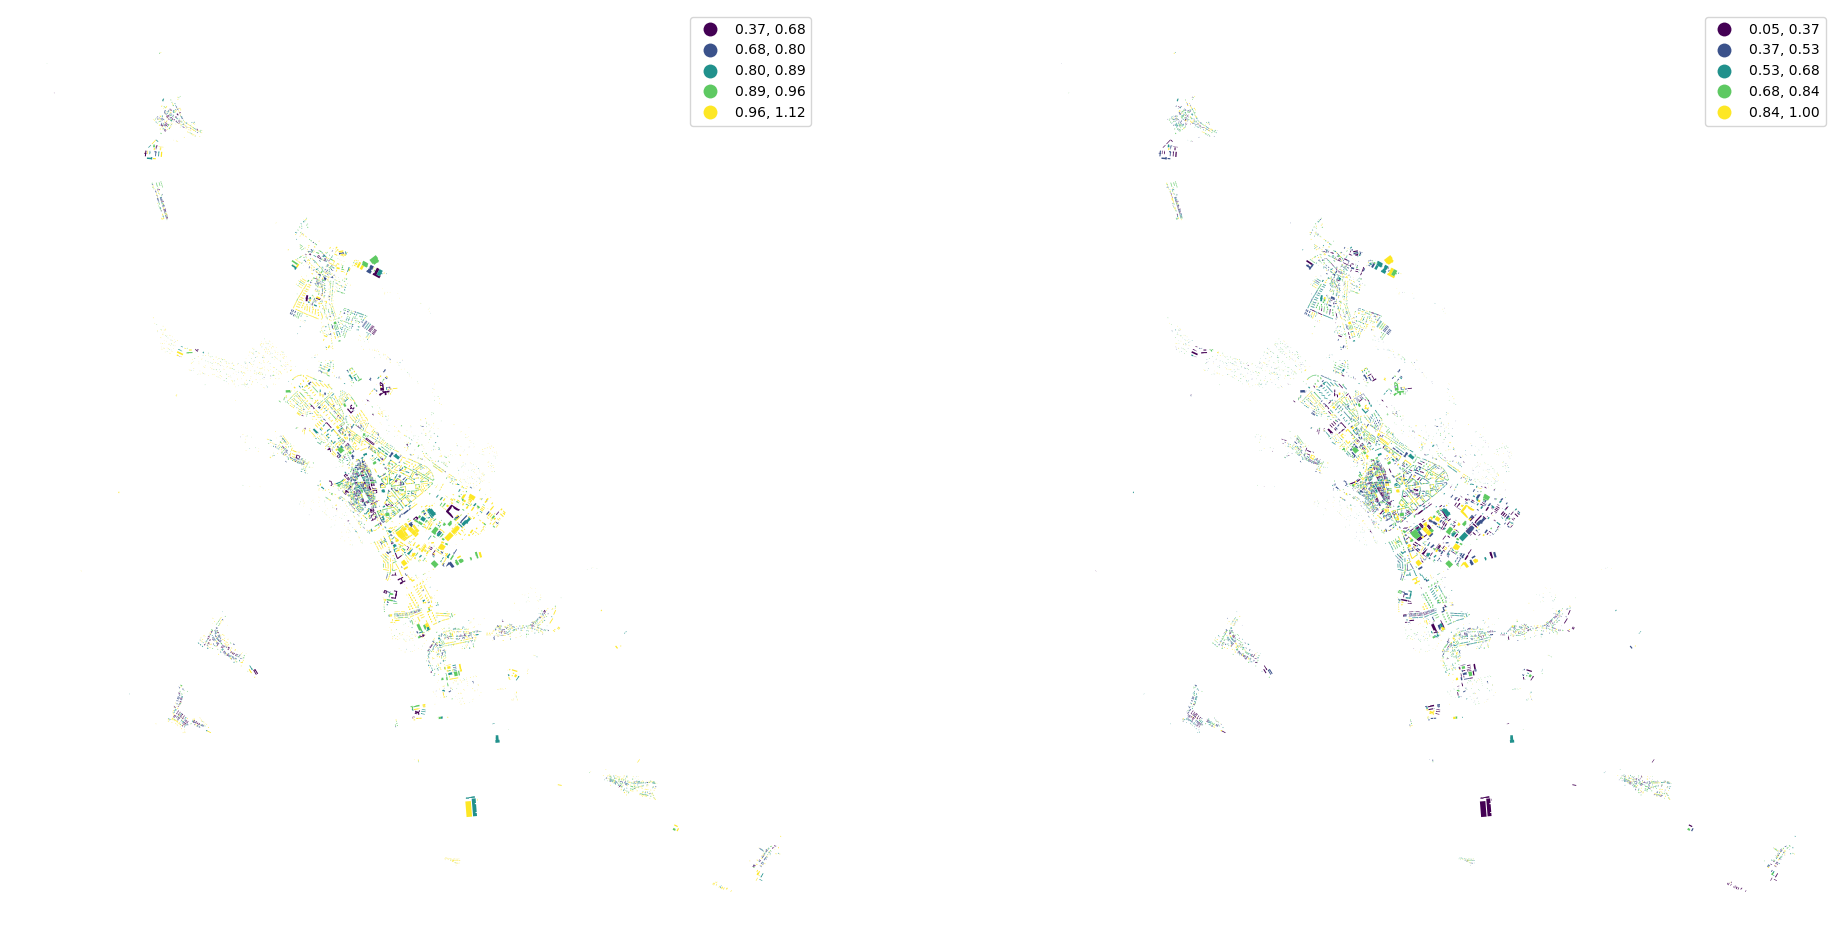

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

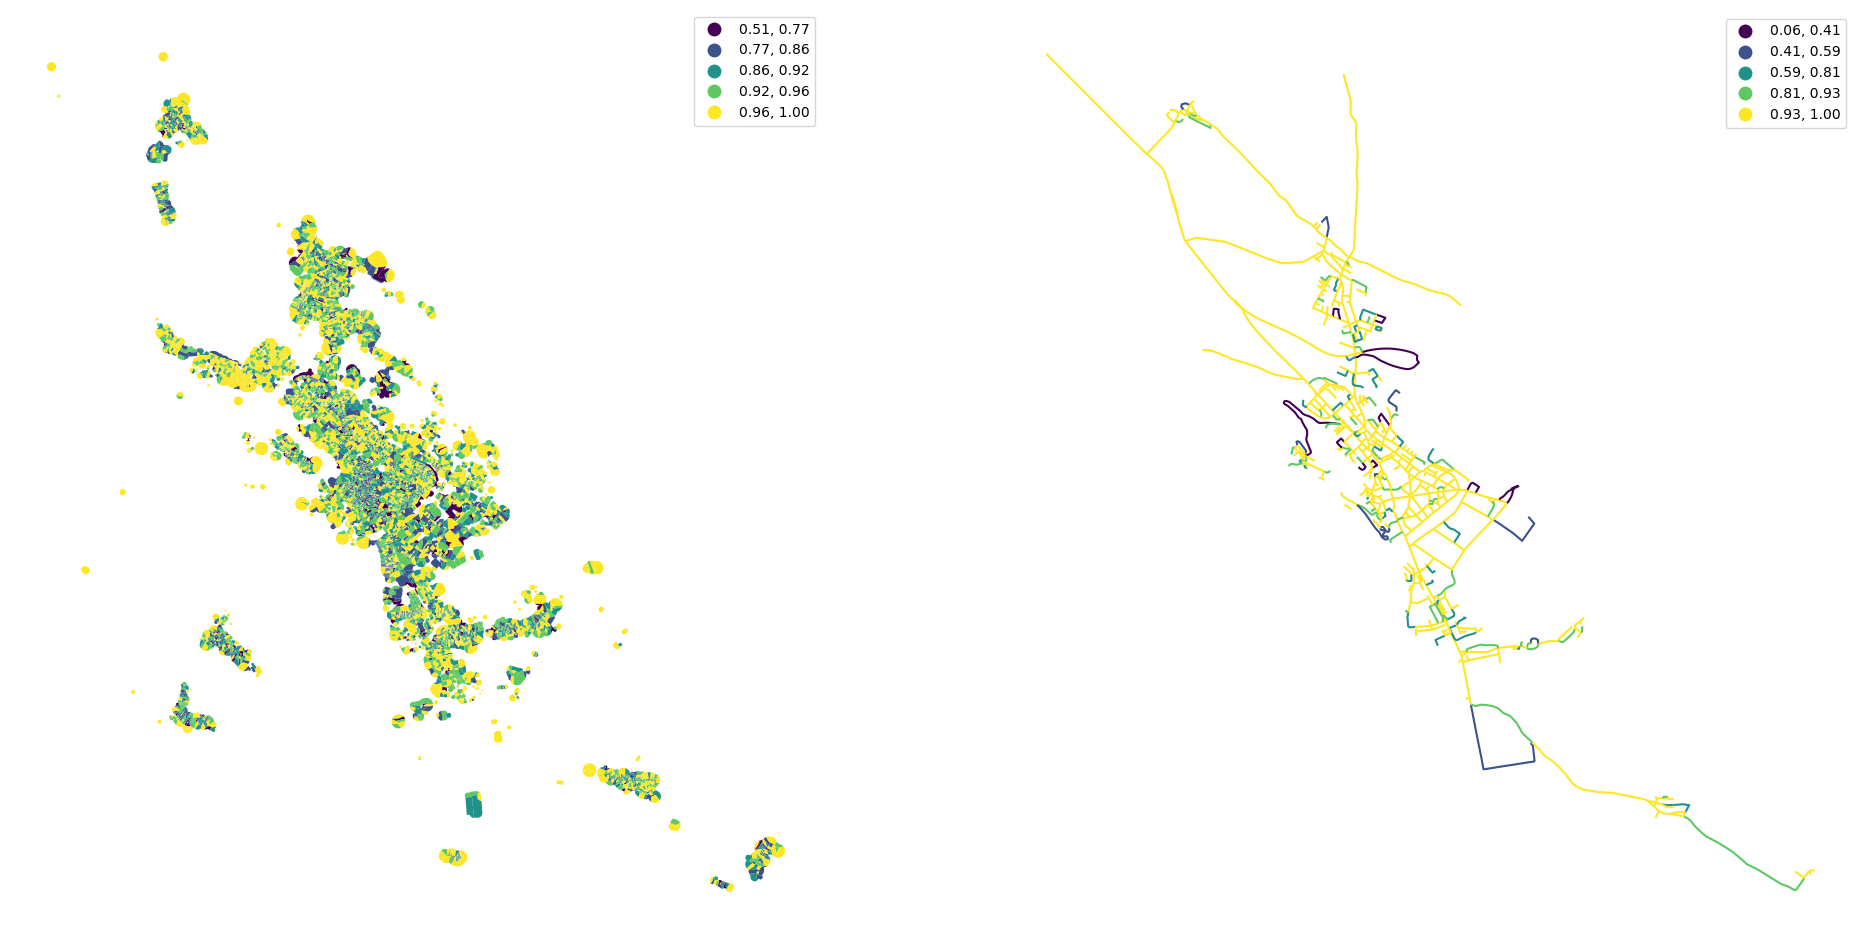

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Spatial distribution

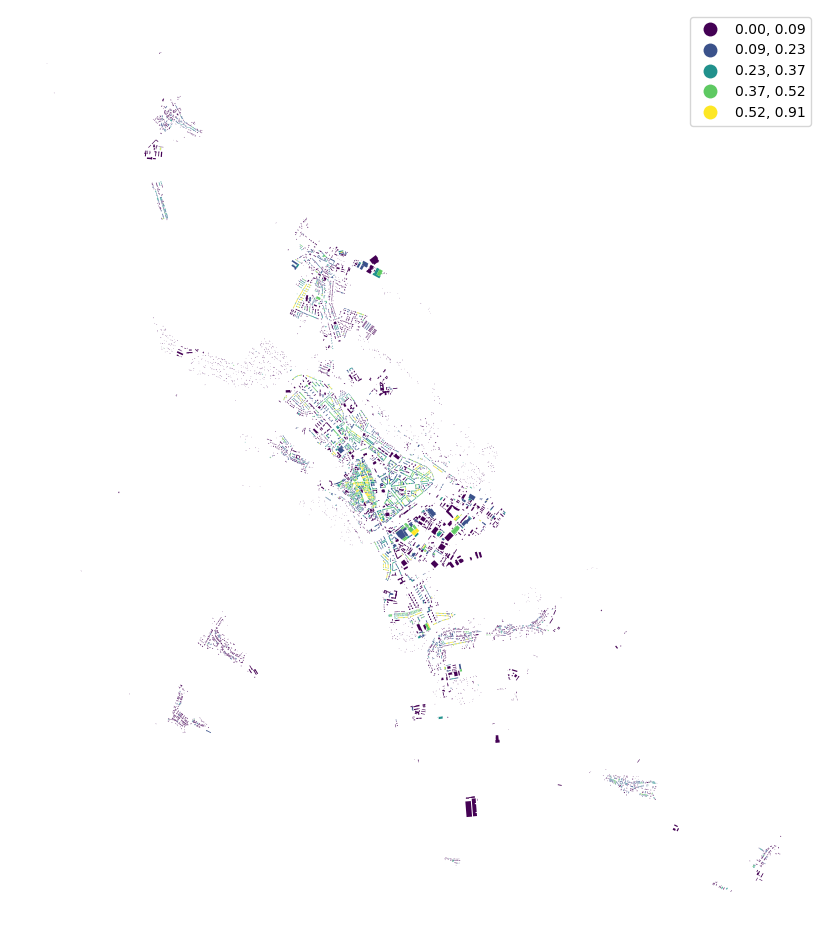

In [23]:
buildings["shared_walls"] = momepy.shared_walls(buildings) / buildings.length
buildings.plot(
    "shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True
).set_axis_off()

Generate spatial graph using `libpysal`.

Due to floating point errors and data quality there are coverage issues with the polygons. Buildings that should have shared walls overlap .001 cm or overlap only at the corners, or have a miniscule distance between them, for example. The same is true for tessellation cells. To account for this we can use fuzzy contiguity when building a graph of spatial relationships.

In [24]:
queen_1 = libpysal.graph.Graph.build_fuzzy_contiguity(tessellation, buffer=0.5)
queen_1

<Graph of 8501 nodes and 47352 nonzero edges indexed by
 [-72, -71, -70, -69, -68, ...]>

In [25]:
tessellation["neighbors"] = momepy.neighbors(
    tessellation, queen_1, weighted=True
)
tessellation["covered_area"] = queen_1.describe(tessellation.area)["sum"]

In [26]:
# limit graph only to buildings
buildings["neighbor_distance"] = momepy.neighbor_distance(
    buildings, queen_1.subgraph(queen_1.unique_ids[queen_1.unique_ids > -1])
)

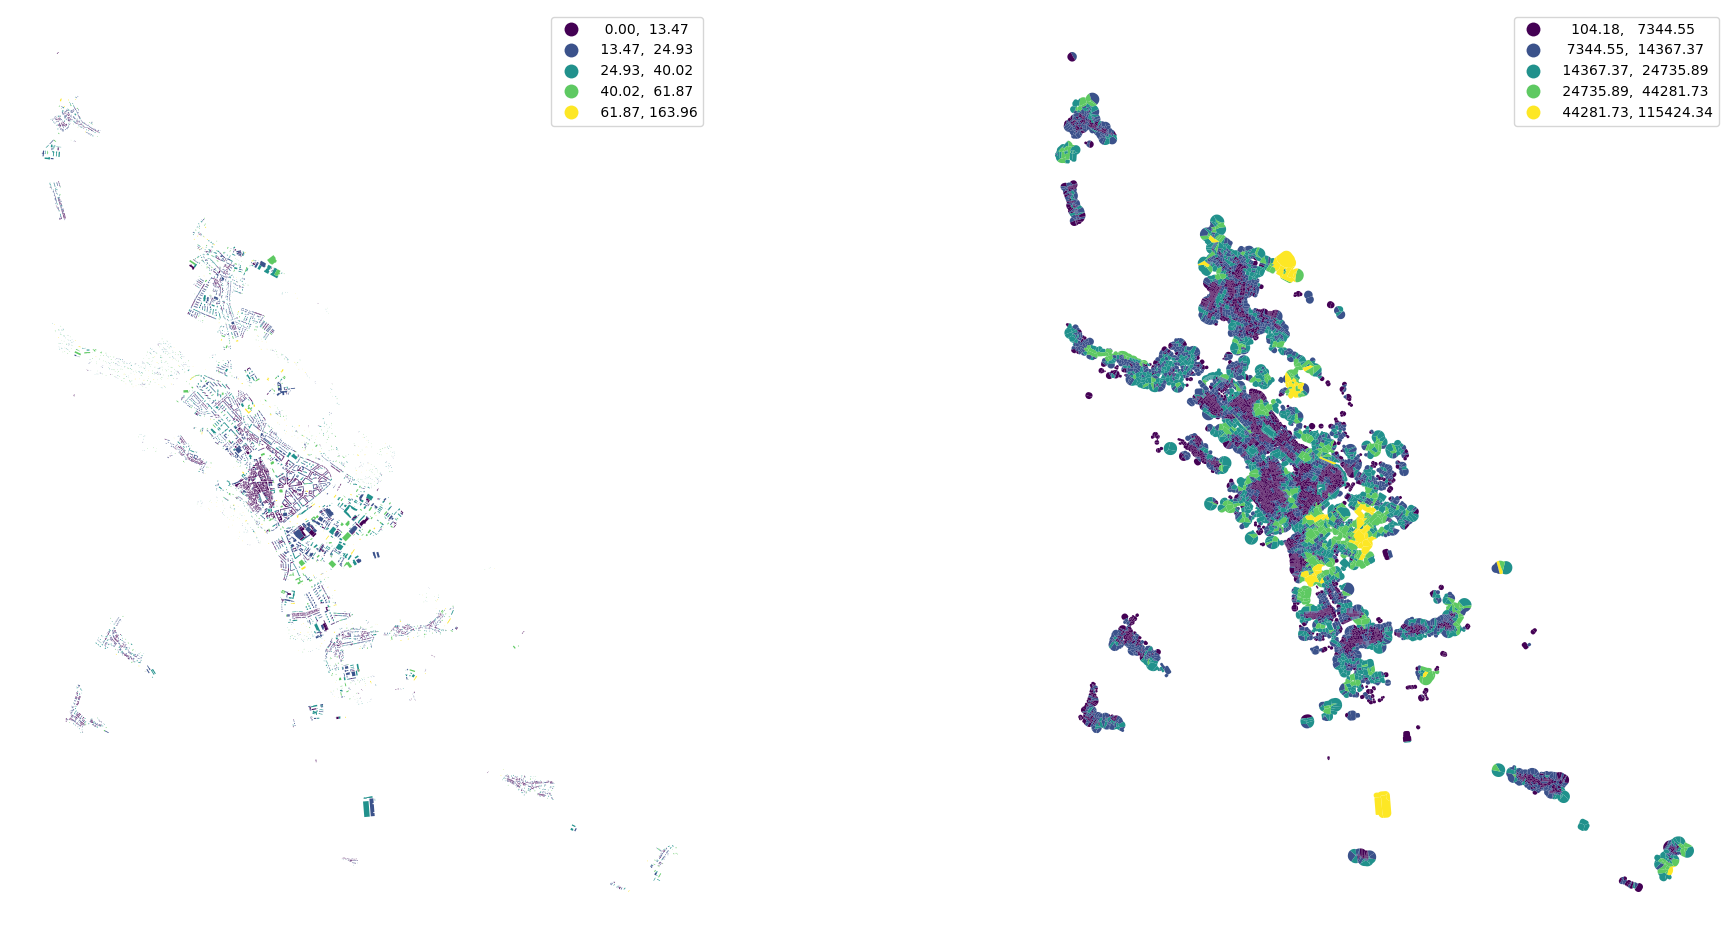

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
tessellation.plot(
    "covered_area", ax=ax[1], scheme="natural_breaks", legend=True
)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [28]:
# here we have to get a higher order graph then subset,
# in order to preserve contiguity infromation across the empty space
queen_3 = queen_1.higher_order(3)

buildings["interbuilding_distance"] = momepy.mean_interbuilding_distance(
    buildings,
    queen_1.subgraph(buildings.index),
    queen_3.subgraph(buildings.index),
)

/Users/martin/dev/pysal/momepy/momepy/distribution.py:375: RuntimeWarning: invalid value encountered in scalar divide
  mean_distances[i] = sub_matrix.sum() / sub_matrix.nnz


In [29]:
buildings_q1 = libpysal.graph.Graph.build_contiguity(buildings, rook=False)
buildings["adjacency"] = momepy.building_adjacency(
    buildings_q1, queen_3.subgraph(queen_3.unique_ids[queen_3.unique_ids > -1])
)

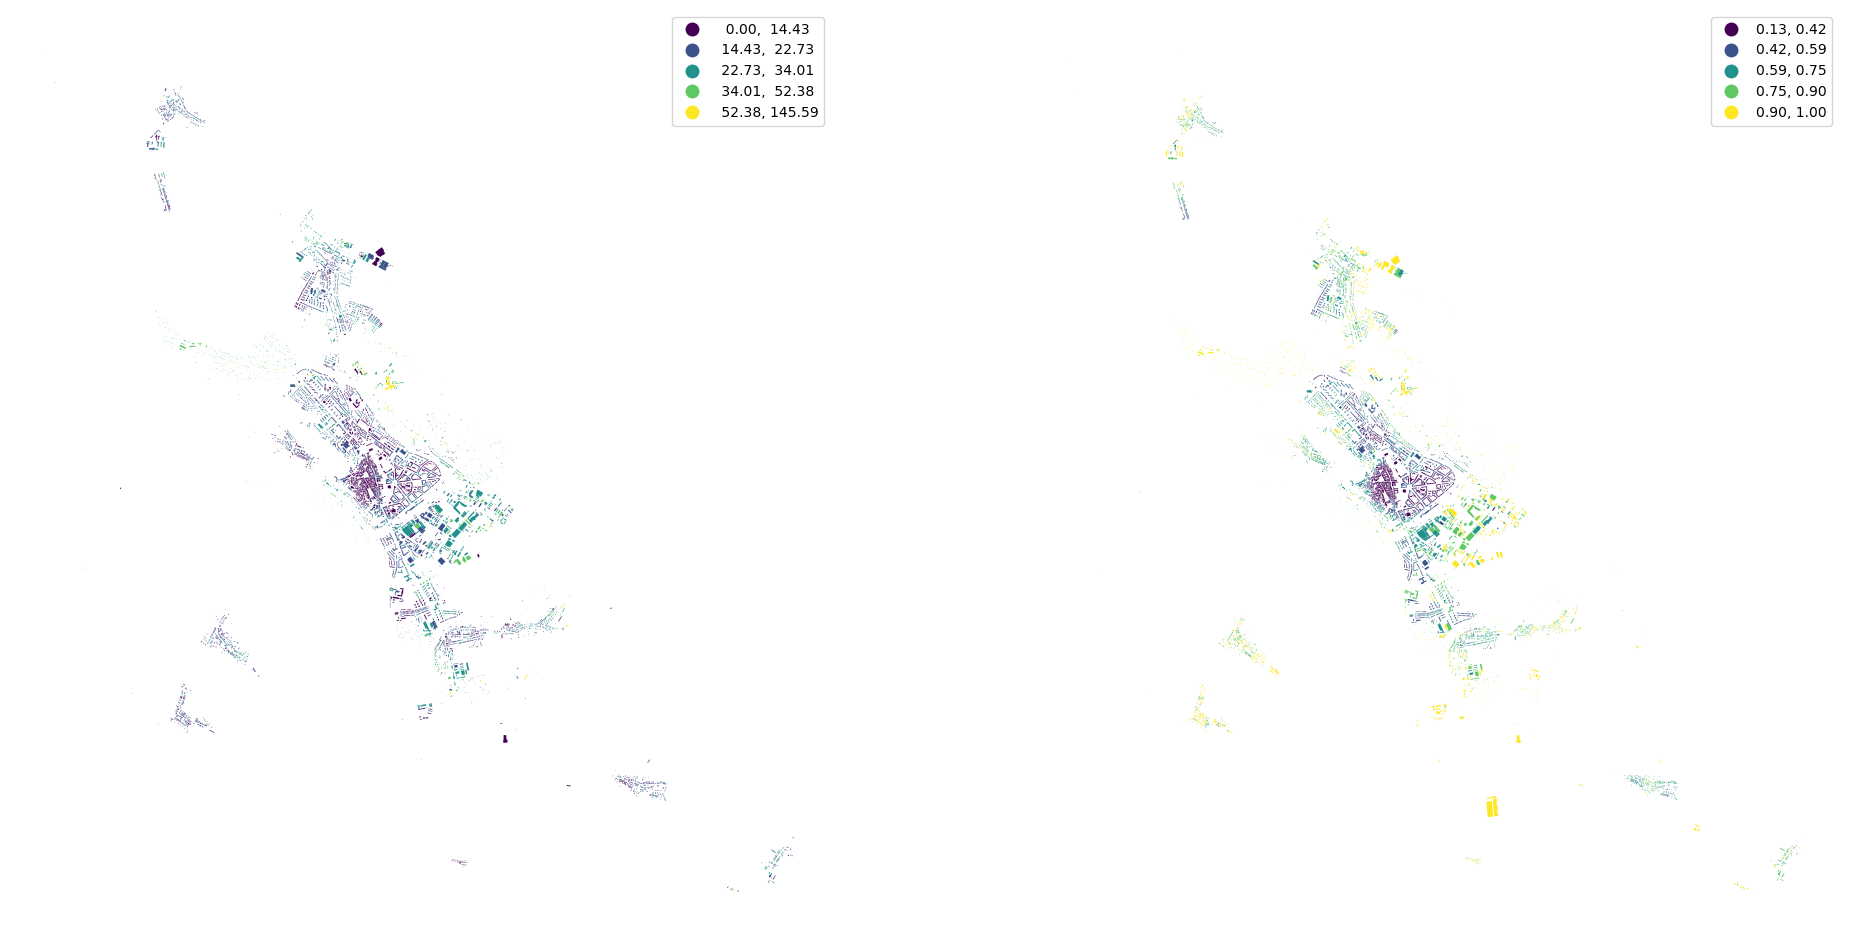

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot(
    "interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True
)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [31]:
profile = momepy.street_profile(streets, buildings)
streets[profile.columns] = profile

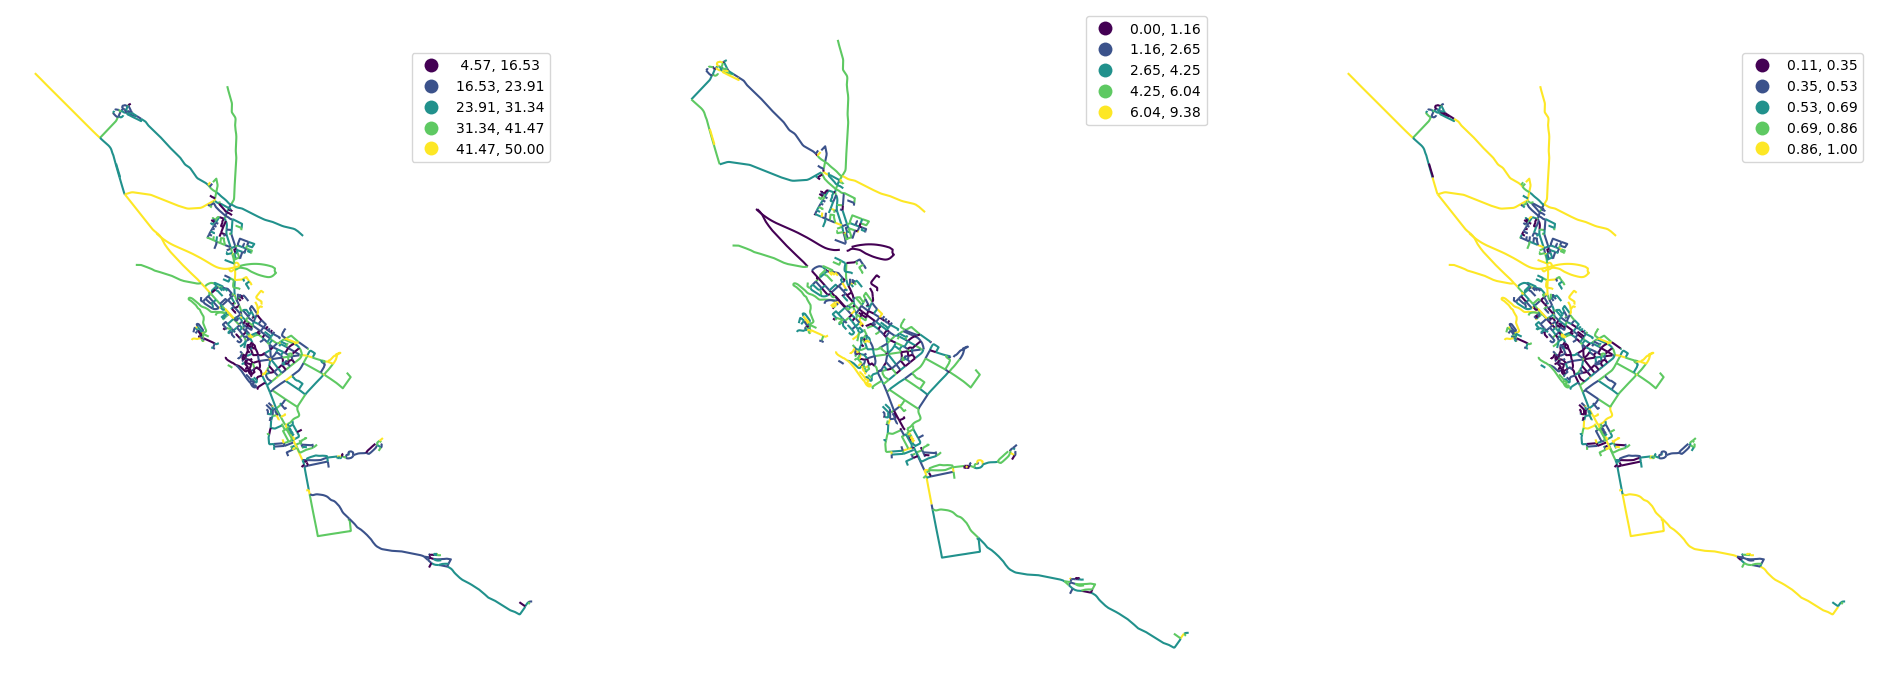

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

### Intensity

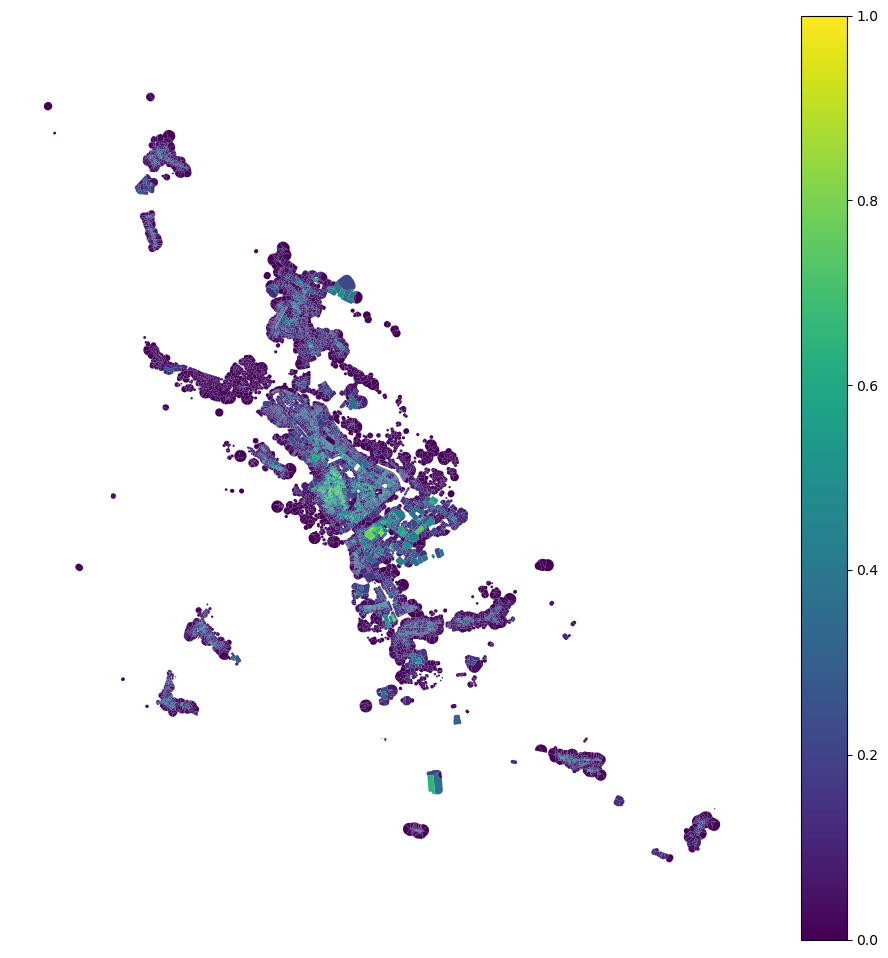

In [33]:
tessellation["car"] = buildings.area / tessellation.area
tessellation.plot(
    "car", figsize=(12, 12), vmin=0, vmax=1, legend=True
).set_axis_off()

### Connectivity

In [34]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, edges = momepy.nx_to_gdf(graph)

  0%|          | 0/630 [00:00<?, ?it/s]

  0%|          | 0/630 [00:00<?, ?it/s]

/Users/martin/dev/pysal/.pixi/envs/default/lib/python3.11/site-packages/mapclassify/classifiers.py:689: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self._classify()


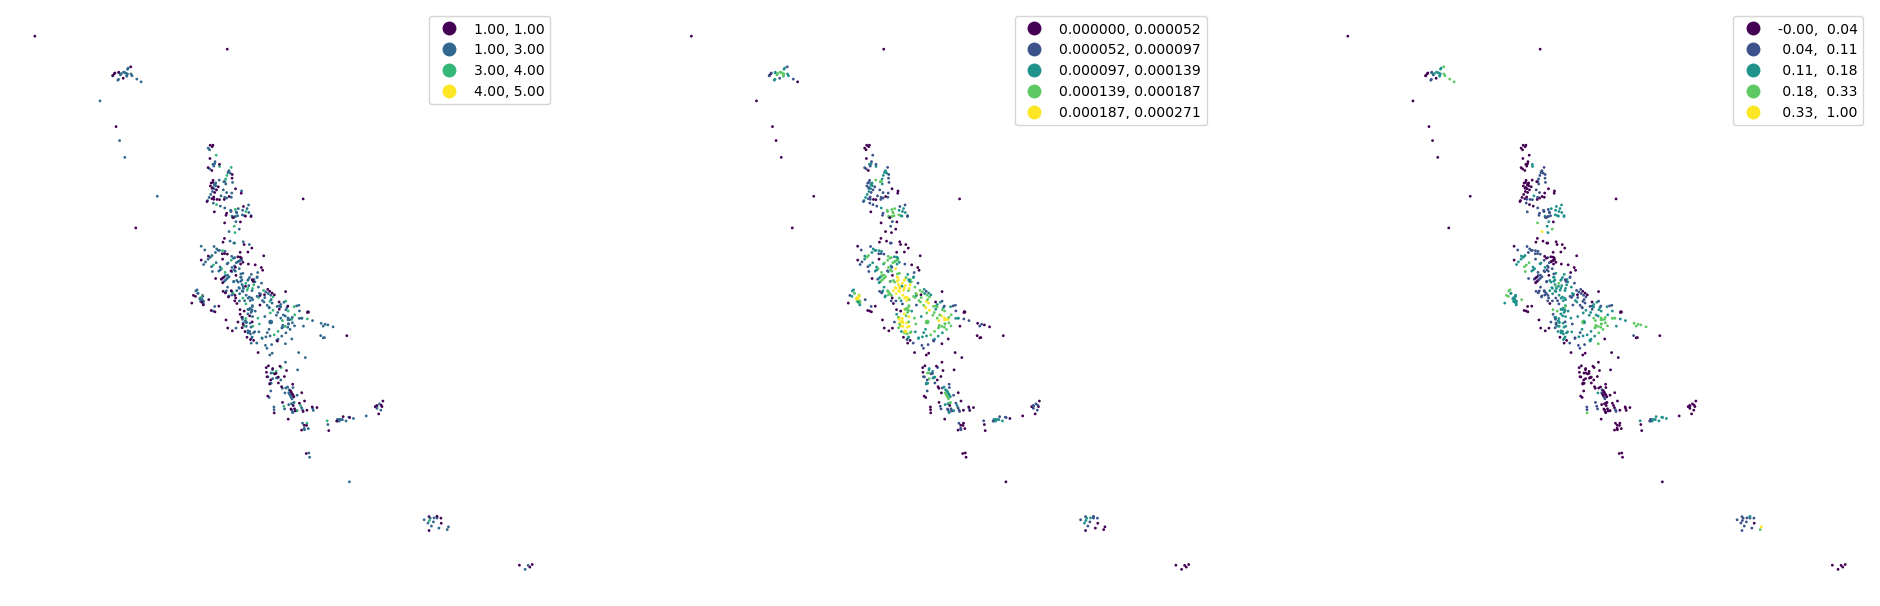

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot(
    "degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1
)
nodes.plot(
    "closeness",
    ax=ax[1],
    scheme="natural_breaks",
    legend=True,
    markersize=1,
    legend_kwds={"fmt": "{:.6f}"},
)
nodes.plot(
    "meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1
)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [36]:
buildings["edge_index"] = momepy.get_nearest_street(buildings, edges)
buildings["node_index"] = momepy.get_nearest_node(
    buildings, nodes, edges, buildings["edge_index"]
)

Link all data together (to tessellation cells or buildings).

In [37]:
tessellation.head()

,enclosure_index,geometry,street_index,tess_area,convexity,neighbors,covered_area,car
-72,11,"POLYGON ((-643068.131 -1193217.971, -643074.29...",NaN,2072.709008,0.919509,0.021340,7089.590409,NaN
-71,17,"POLYGON ((-642986.232 -1193219.882, -643005.10...",NaN,1301.566392,0.985102,0.026274,19408.758266,NaN
-70,23,"POLYGON ((-642186.353 -1195342.862, -642146.55...",NaN,1873.371141,0.984777,0.015997,11409.651059,NaN
-69,30,"POLYGON ((-641373.768 -1194095.219, -641372.33...",NaN,124.238315,1.000000,0.048145,17492.769047,NaN
-68,46,"POLYGON ((-643611.161 -1191667.968, -643640.44...",NaN,2989.219971,1.000000,0.007805,6763.400352,NaN


In [38]:
buildings.head()

,geometry,street_index,building_area,eri,elongation,shared_walls,neighbor_distance,interbuilding_distance,adjacency,edge_index,node_index
0,"POLYGON ((-642818.791 -1194246.301, -642822.90...",335.0,1350.711109,0.464112,0.436115,0.026712,49.905728,23.352260,0.631579,521.0,306.0
1,"POLYGON ((-643052.212 -1193474.914, -643069.77...",468.0,770.419570,0.742491,0.971687,0.000000,18.909292,6.812153,0.341463,153.0,397.0
2,"POLYGON ((-642796.708 -1193674.586, -642795.74...",353.0,1830.570622,0.544350,0.850052,0.170633,17.551139,13.119138,0.365385,156.0,73.0
3,"POLYGON ((-642960.567 -1193475.288, -642969.02...",476.0,532.527489,0.646696,0.629206,0.499747,1.892698,8.104306,0.315789,547.0,323.0
4,"POLYGON ((-642973.521 -1193481.346, -642960.58...",476.0,765.313279,0.630997,0.734407,0.301092,10.873376,5.020349,0.232558,547.0,401.0


In [39]:
tessellation[buildings.columns.drop(["geometry", "street_index"])] = (
    buildings.drop(columns=["geometry", "street_index"])
)
merged = tessellation.merge(
    edges.drop(columns="geometry"),
    left_on="edge_index",
    right_index=True,
    how="left",
)
merged = merged.merge(
    nodes.drop(columns="geometry"),
    left_on="node_index",
    right_index=True,
    how="left",
)

In [40]:
merged.columns

Index(['enclosure_index', 'geometry', 'street_index', 'tess_area', 'convexity',
       'neighbors', 'covered_area', 'car', 'building_area', 'eri',
       'elongation', 'shared_walls', 'neighbor_distance',
       'interbuilding_distance', 'adjacency', 'edge_index', 'node_index',
       '_status', 'highway', 'length', 'linearity', 'width', 'openness',
       'width_deviation', 'mm_len', 'node_start', 'node_end', 'x', 'y',
       'degree', 'closeness', 'meshedness', 'nodeID'],
      dtype='object')

In [41]:
attr_columns = merged.columns.drop(
    [
        "enclosure_index",
        "street_index",
        "node_index",
        "edge_index",
        "nodeID",
        "mm_len",
        "node_start",
        "node_end",
        "geometry",
        "x",
        "y",
        "_status",
        "highway",
    ]
)

In [42]:
merged[attr_columns]

,tess_area,convexity,neighbors,covered_area,car,building_area,eri,elongation,shared_walls,neighbor_distance,interbuilding_distance,adjacency,length,linearity,width,openness,width_deviation,degree,closeness,meshedness
-72,2072.709008,0.919509,0.021340,7089.590409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-71,1301.566392,0.985102,0.026274,19408.758266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-70,1873.371141,0.984777,0.015997,11409.651059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-69,124.238315,1.000000,0.048145,17492.769047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-68,2989.219971,1.000000,0.007805,6763.400352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8424,1133.261567,0.953384,0.029137,11084.061508,0.058147,65.895275,0.999856,0.605477,0.0000,23.708275,35.109635,0.947368,332.945828,0.998279,39.230975,0.820513,2.025614,3.0,0.000010,0.000000
8425,3364.010968,0.791492,0.019931,35462.264954,0.314831,1059.094497,0.898830,0.746671,0.1065,26.592852,32.081612,0.870968,610.009981,0.998920,29.112032,0.732877,3.592120,3.0,0.000012,0.000000
8426,9026.810317,0.757151,0.012527,46088.507155,0.023834,215.142248,0.999734,0.755583,0.0000,98.760951,32.273475,0.954545,610.009981,0.998920,29.112032,0.732877,3.592120,3.0,0.000012,0.000000
8427,994.598128,0.920472,0.027559,5288.381490,0.140239,139.481788,1.000021,0.956042,0.0000,11.995571,43.629354,1.000000,369.705606,0.335753,24.651918,0.598214,3.846055,3.0,0.000053,0.133333


## Unsupervised machine learning

## Morphotopes

The first step in the analysis is to group our elements into morphotopes using the $SA^3$ algorithm. Morphotopes are defined as:

> “the smallest urban locality obtaining distinctive character among their neighbours from their particular combination of constituent morphological elements.”

We do this to create contiguous units which can act as the base of the hierarchical analysis. 

This is also an example of the second way of using spatial relationships - directly embeding them in the algorithm.

In [43]:
# limit the analysis to only the tessellation cells with buildings in them
# and only to the selected columns
training_data = merged.loc[merged.index > -1, attr_columns]

# standardise data and fill NAs with 0
res = StandardScaler().fit_transform(training_data)
standardised_data = pd.DataFrame(res, columns=attr_columns).fillna(0)

In [44]:
clusterer = SA3(
    standardised_data,
    queen_1.subgraph(queen_1.unique_ids[queen_1.unique_ids > -1]),
    standardised_data.columns,
    min_cluster_size=75,
    extraction="leaf",
    linkage="ward",
)
clusterer.solve()
clusterer.labels_.value_counts()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


-1     1845
 40     290
 13     264
 41     219
 11     204
 34     195
 32     193
 2      175
 25     163
 14     156
 9      151
 7      151
 22     149
 6      149
 4      146
 26     144
 17     133
 15     131
 33     127
 12     124
 42     121
 1      120
 44     118
 10     115
 31     111
 48     111
 51     108
 36     107
 47     103
 24     103
 45     100
 52      99
 19      97
 5       96
 35      94
 30      93
 16      92
 27      87
 18      87
 29      87
 53      85
 43      84
 21      83
 46      83
 23      82
 49      81
 20      80
 50      79
 8       79
 38      78
 54      78
 37      77
 0       76
 28      76
 39      75
 3       75
Name: count, dtype: int64

This is what an example morphotope looks like. In this case it is the industrual area of the town.

<Axes: >

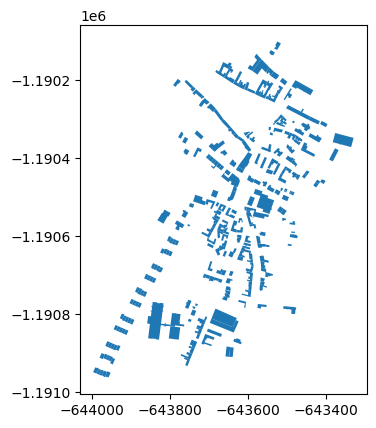

In [45]:
buildings[clusterer.labels_ == clusterer.labels_.value_counts().index[1]].plot()

## Clustering

Now we can use the morphotopes to create a hierarchical taxonomy of urban structure. To do this we use simple dendrogram clustering models.

In [46]:
morph_clusters = clusterer.labels_

Aggregate morphological data by morphotopes.

In [47]:
grouped_data = standardised_data.groupby(morph_clusters).median()
if -1 in grouped_data.index:
    grouped_data = grouped_data.iloc[1:]

Build the tree.

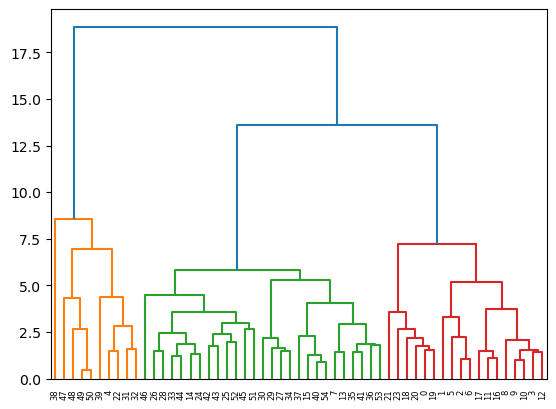

In [48]:
linkage_matrix = hierarchy.linkage(grouped_data, method="ward")

_ = hierarchy.dendrogram(linkage_matrix)

From the tree, you can then extract flat clusters at a selected distance.

In [49]:
morphotope_labels = hierarchy.fcluster(
    linkage_matrix, t=4, criterion="distance"
)
pd.Series(morphotope_labels).value_counts()

6     12
13     8
11     6
10     6
12     4
3      4
9      4
8      4
1      3
5      1
4      1
7      1
2      1
Name: count, dtype: int64

And assign those to buildings via the morphotopes.

In [50]:
final_labels = pd.Series(morph_clusters).replace(
    pd.Series(morphotope_labels, index=grouped_data.index).to_dict()
)
final_labels.value_counts()

-1     1845
 6     1399
 13     973
 10     920
 3      599
 9      576
 12     540
 11     505
 8      462
 1      271
 2      103
 7       83
 5       78
 4       75
Name: count, dtype: int64

The $SA^3$ algorithm assigns buildings that are not morphologically similar to another group, or are not numerous enough to form a morphotope to a noise cluster. One way to deal with this noise cluster is to assign each tessellation cell in to its nearest cluster. We do this next.

In [51]:
cluster_centres = standardised_data.groupby(final_labels).median().iloc[1:]
tree = KDTree(cluster_centres)
dists, idxs = tree.query(standardised_data[final_labels == -1], k=5)
final_labels[final_labels == -1] = idxs[:, 0] + 1

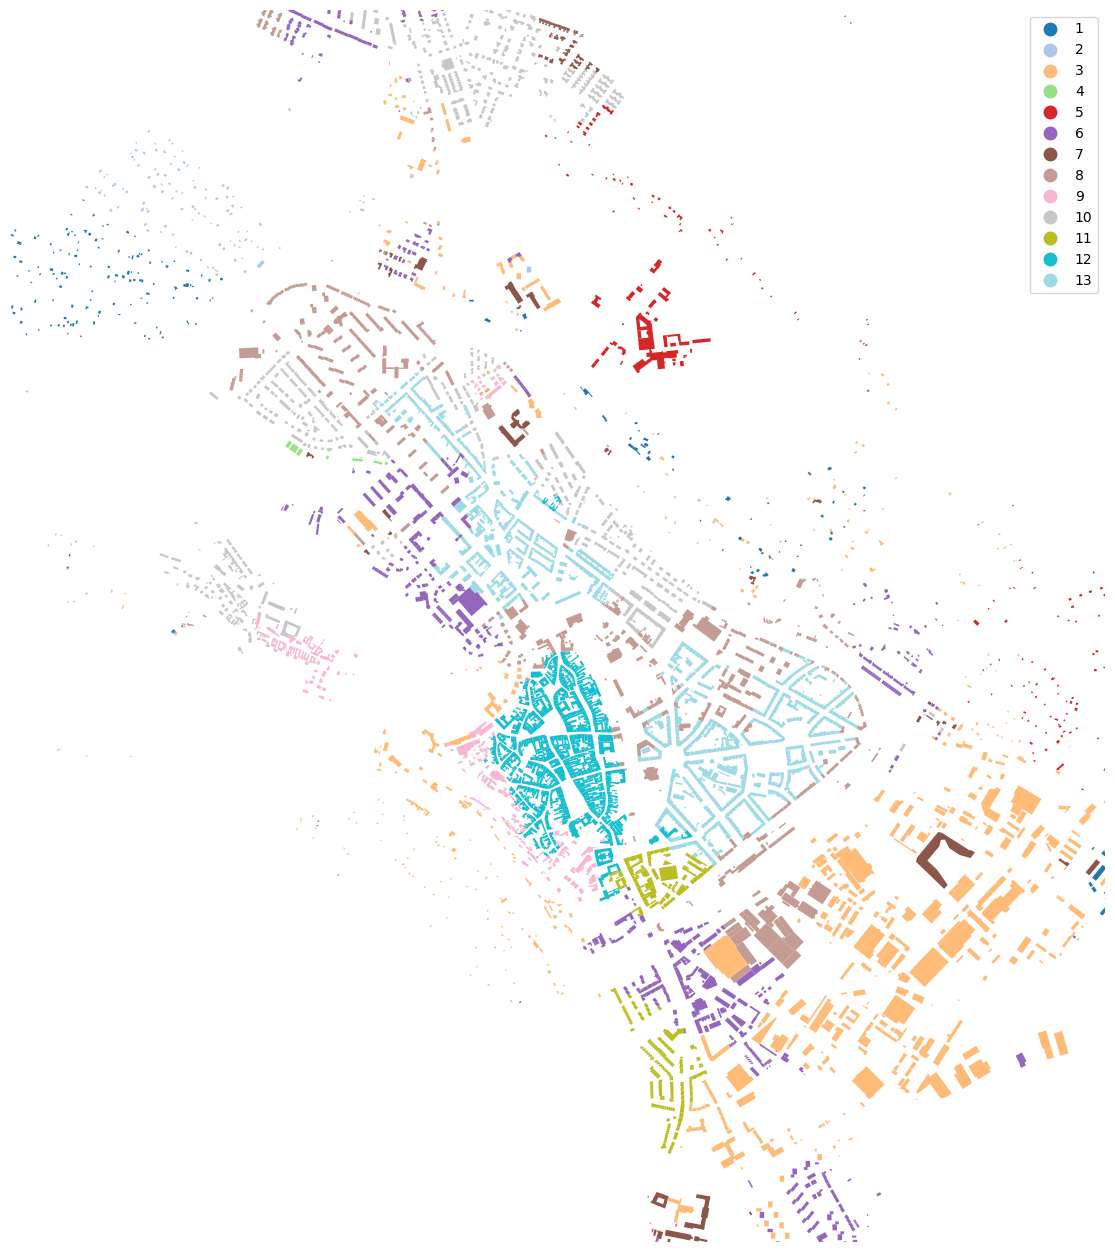

In [52]:
ax = buildings.plot(
    final_labels, categorical=True, figsize=(16, 16), legend=True, cmap="tab20"
)
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()